In [2]:
# This file will go thorugh the data and explore the missing values


import pandas as pd
import seaborn as sns
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import missingno as msno
import calendar
import geopandas as gpd
from shapely.geometry import Point
from mpl_toolkits.basemap import Basemap
from pyrealm import pmodel
from sklearn.inspection import permutation_importance
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from geopy.geocoders import Nominatim
from geopy.exc import GeocoderTimedOut
from geopy.extra.rate_limiter import RateLimiter
import pycountry_convert as pc
from sklearn.model_selection import StratifiedShuffleSplit
from matplotlib.dates import DateFormatter




In [3]:
# import the dfs from the data_processing file

full_date=pd.read_csv('/Users/abigailbase/PROJECT FILES/FINAL DFs/full_date.csv')

In [4]:
full_date.head() #inspect the df

,SITE_ID,TA_F,PA_F,VPD_F,P_F,WS_F,PPFD_IN,PPFD_OUT,CO2_F_MDS,TS_F_MDS_1,SWC_F_MDS_1,NEE_VUT_REF,GPP_DT_VUT_REF,YEAR,MONTH,DAY
0,CA-NS3,-12.541,98.042,0.719,0.336,2.339,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,0.243493,0.321625,2001,1,1
1,CA-NS3,-18.309,98.586,0.611,0.099,0.816,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,0.386648,0.721820,2001,1,2
2,CA-NS3,-13.912,98.081,0.630,0.158,1.418,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,0.301790,1.202700,2001,1,3
3,CA-NS3,-10.072,96.457,0.936,1.441,3.089,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,0.243493,0.421478,2001,1,4
4,CA-NS3,-20.642,97.479,0.631,0.392,1.446,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,0.386648,0.540661,2001,1,5


In [5]:
print(full_date.shape) #580386

(580386, 16)


In [10]:
# import FLUXNET tower site information 
# source: https://fluxnet.org/sites/site-list-and-pages/

site_key=pd.read_csv('/Users/abigailbase/PROJECT FILES/site_key.csv')

In [11]:
## prepare for left join
    
site_key_merge=site_key.drop(columns='SITE_NAME') 

In [12]:
# merge the FLUXNET data and the site info dfs

final_df=pd.merge(full_date,site_key_merge,on='SITE_ID')

In [13]:
final_df.head() #inspect

,SITE_ID,TA_F,PA_F,VPD_F,P_F,WS_F,PPFD_IN,PPFD_OUT,CO2_F_MDS,TS_F_MDS_1,SWC_F_MDS_1,NEE_VUT_REF,GPP_DT_VUT_REF,YEAR,MONTH,DAY,LAT,LONG,IGBP
0,CA-NS3,-12.541,98.042,0.719,0.336,2.339,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,0.243493,0.321625,2001,1,1,55.9117,-98.3822,ENF
1,CA-NS3,-18.309,98.586,0.611,0.099,0.816,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,0.386648,0.721820,2001,1,2,55.9117,-98.3822,ENF
2,CA-NS3,-13.912,98.081,0.630,0.158,1.418,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,0.301790,1.202700,2001,1,3,55.9117,-98.3822,ENF
3,CA-NS3,-10.072,96.457,0.936,1.441,3.089,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,0.243493,0.421478,2001,1,4,55.9117,-98.3822,ENF
4,CA-NS3,-20.642,97.479,0.631,0.392,1.446,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,0.386648,0.540661,2001,1,5,55.9117,-98.3822,ENF


In [14]:
# assign hemisphere to all points in the merged df

final_df['hemisphere']=final_df['LAT'].apply(lambda x: 'NH' if x>=0 else 'SH')

In [18]:
# group by hemisphere and year for anaylsis of observations over time

year_hs_count=final_df.groupby(['hemisphere','YEAR',]).size().reset_index(name='counts')

In [19]:
# seperate by hemisphere

NH_year=year_hs_count[year_hs_count['hemisphere']=='NH']
SH_year=year_hs_count[year_hs_count['hemisphere']=='SH']

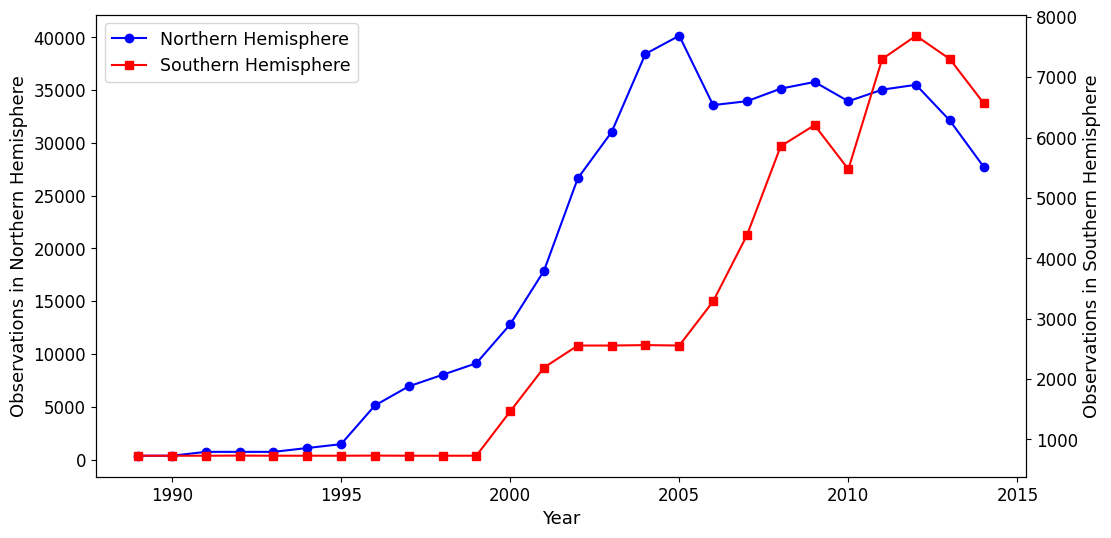

In [20]:
# plot of observations overtime per hemisphere with NH on primary axis and SH on secondary axis 

fig, ax3 = plt.subplots(figsize=(12, 6))


ax3.set_xlabel('Year',fontsize=13)
ax3.set_ylabel('Observations in Northern Hemisphere',fontsize=13)
NH_line2=ax3.plot(NH_year['YEAR'], NH_year['counts'], 
                  color='blue', marker='o', 
                  label='Northern Hemisphere')

ax3.tick_params(axis='y')
ax3.tick_params(axis='y', labelsize=12) 
ax3.tick_params(axis='x', labelsize=12)

ax4 = ax3.twinx()
ax4.set_ylabel('Observations in Southern Hemisphere',fontsize=13)
SH_line2=ax4.plot(SH_year['YEAR'], SH_year['counts'], color='red', marker='s', label='Southern Hemisphere')
ax4.tick_params(axis='y')
ax4.tick_params(axis='y', labelsize=12)  

lines2 = NH_line2 + SH_line2
labels2 = [line.get_label() for line in lines2]
ax3.legend(lines2, labels2, loc='upper left',fontsize=12.5)

In [51]:
# remove pre 2000 data due to low count

post_2000=final_df[final_df['YEAR']>=2000]

In [24]:
print(post_2000.shape) #198678

(198678, 20)


In [25]:
post_2000.isna().sum() #No missing values in each column

SITE_ID                0
TA_F                5478
PA_F                5478
VPD_F               5478
P_F                 5478
WS_F                5478
PPFD_IN            39444
PPFD_OUT          115043
CO2_F_MDS           5478
TS_F_MDS_1         12052
SWC_F_MDS_1        41634
NEE_VUT_REF         5478
GPP_DT_VUT_REF      5478
YEAR                   0
MONTH                  0
DAY                    0
LAT                    0
LONG                   0
IGBP                   0
hemisphere             0
dtype: int64

In [26]:
post_2000=post_2000.drop(columns='PPFD_OUT') #drop PPFD out

In [52]:
# investigate the different land cover types ahead of stratified sampling
# to ensure they are accuratly represented in the sample.

total_ID= post_2000.groupby('SITE_ID').size().reset_index(name='counts')

In [53]:
# merge sites information with the counts

site_counts=pd.merge(site_key,total_ID,on='SITE_ID')

In [54]:
# additional land cover information (IGBP codes)
# source: https://fluxnet.org/data/badm-data-templates/igbp-classification/

IGBP=pd.read_csv('/Users/abigailbase/PROJECT FILES/IGBP_code.csv')

In [55]:
# assign hemispheres to the site locations

site_counts['hemisphere']=site_counts['LAT'].apply(lambda x: 'NH' if x>=0 else 'SH')

In [56]:
# group counts by hemisphere 

land_counts=site_counts.groupby(['hemisphere','IGBP',]).size().reset_index(name='counts')

NH_land=land_counts[land_counts['hemisphere']=='NH']
SH_land=land_counts[land_counts['hemisphere']=='SH']

In [63]:
print(SH_land['counts'].sum()) #29
print(NH_land['counts'].sum()) #176

29
176


In [39]:
# merge on the common IGBP types

NH_land = NH_land.rename(columns={'counts': 'NH_count'})
SH_land = SH_land.rename(columns={'counts': 'SH_count'})

# Merge the dataframes on 'IGBP'
combined_bar = pd.merge(NH_land[['IGBP', 'NH_count']], SH_land[['IGBP', 'SH_count']], on='IGBP', how='outer')


In [40]:
# replace missing values with 0 

combined_bar = combined_bar.fillna(0)

In [43]:
# IGBP types to drop that dont appear in the df

to_drop=['BSV','CVM','DNF','URB']

In [44]:
# remove rows containing the IGBPS that dont appear

IGBP = IGBP[~IGBP['IGBP'].isin(to_drop)]


In [46]:
legend_labels = {'NH_count': 'Northern Hemisphere', 'SH_count': 'Southern Hemisphere'}


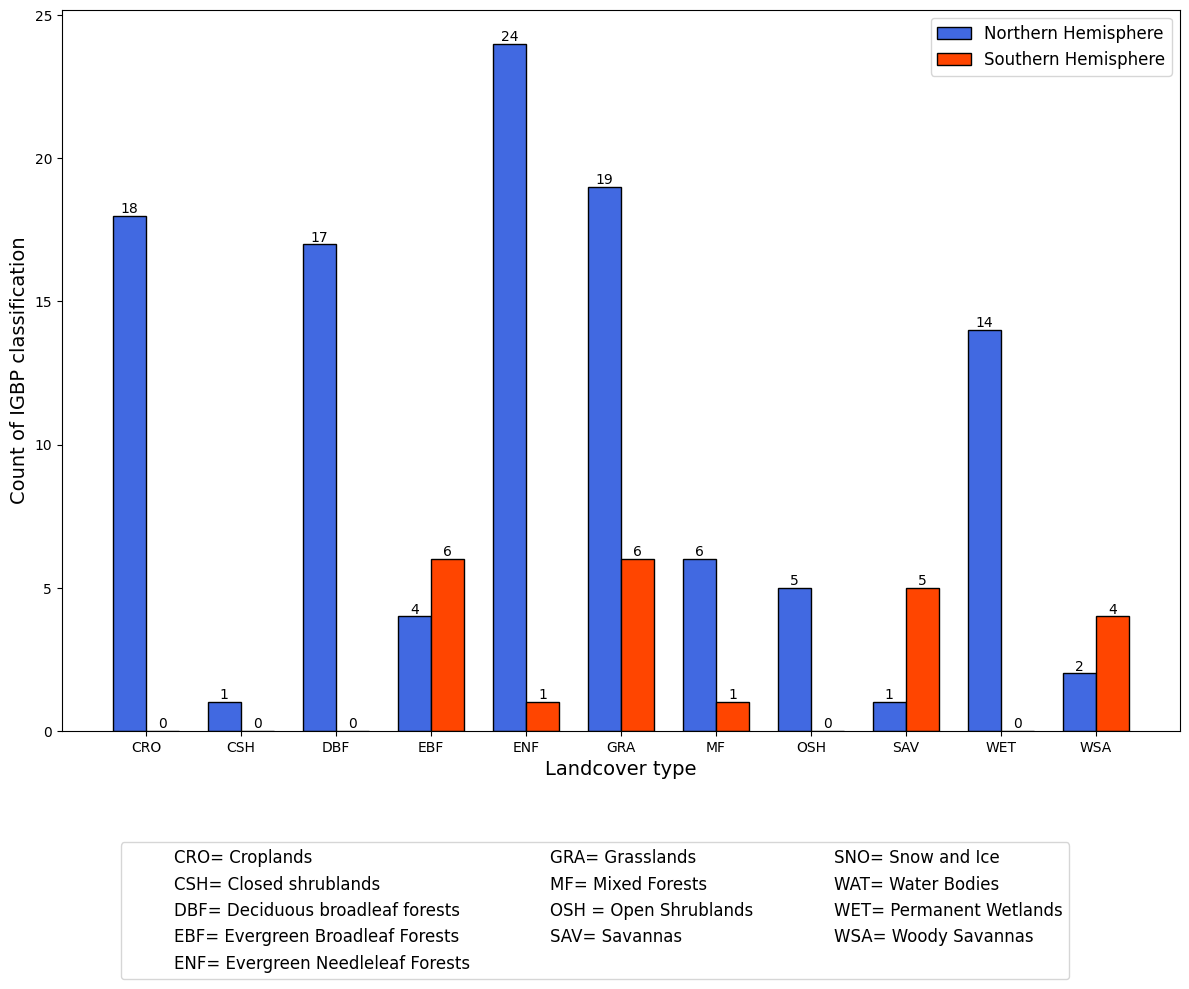

In [47]:
### grouped bar chart showing the IGBP types that appear in the df split by hemisphere

fig, ax = plt.subplots(figsize=(12,8))

# width for the bars
bar_width = 0.35
index = np.arange(len(combined_bar['IGBP']))

# plot bars for NH and SH
bars1 = ax.bar(index, combined_bar['NH_count'], bar_width, label='NH_count',color='royalblue',edgecolor='black')
bars2 = ax.bar(index + bar_width, combined_bar['SH_count'], bar_width, label='SH_count',color='orangered',edgecolor='black')

ax.set_xlabel(('Landcover type'),fontsize=14)
ax.set_ylabel(('Count of IGBP classification'),fontsize=14)
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(combined_bar['IGBP'])


handles, labels = ax.get_legend_handles_labels()

legend_labels = {'NH_count': 'Northern Hemisphere', 'SH_count': 'Southern Hemisphere'}

new_labels = [legend_labels[label] for label in labels]

ax.legend(handles, new_labels, fontsize=12)

# add labels above the bars
for bar in bars1:
    height = bar.get_height()
    if np.isfinite(height):
        ax.text(bar.get_x() + bar.get_width() / 2.0, height, f'{int(height)}', ha='center', va='bottom')

for bar in bars2:
    height = bar.get_height()
    if np.isfinite(height):
        ax.text(bar.get_x() + bar.get_width() / 2.0, height, f'{int(height)}', ha='center', va='bottom')

legend_elements = []
for idx, row in IGBP.iterrows():
    legend_elements.append(plt.Line2D([0], [0], color='black', lw=0, label=f"{row['IGBP']}= {row['Desc']}"))
        
fig.legend(handles=legend_elements, loc='upper center', bbox_to_anchor=(0.5, -0.05), ncol=3, frameon=True,fontsize=12)

        
plt.xticks()  
plt.tight_layout()  
plt.show()

---

In [ ]:
# going to perform a straisfied sample on the entire df to lower the selection

In [66]:
strat1=post_2000.copy()

In [67]:
post_2000.shape

(537661, 20)

In [68]:
# split by hemisphere

NH1=strat1[strat1['hemisphere']=='NH']
SH1=strat1[strat1['hemisphere']=='SH']

In [69]:
#calculate proportion of NH and SH in df to ensure accurate representation 

nh_prop=len(NH1)/len(strat1)
sh_prop=len(SH1)/len(strat1)

In [78]:
#smaller stratified sample to reduce comp demand. 

total_size=1000

In [79]:
nh_sample_size = int(total_size * nh_prop)
sh_sample_size = total_size - nh_sample_size

In [80]:
# function for perfomring stratified sample

def stratified_sample(data, strata_column, sample_size):
    data = data.copy()  # Ensure we are working with a copy of the data
    data['strata'] = data[strata_column]
    test_size = sample_size / len(data)
    
    split = StratifiedShuffleSplit(n_splits=1, test_size=test_size, random_state=42)
    
    for train_index, test_index in split.split(data, data['strata']):
        sample = data.iloc[test_index]
    
    sample = sample.drop(columns=['strata'])
    return sample

In [81]:
# take samples independantly 

nh_sample = stratified_sample(NH1, 'IGBP', nh_sample_size)
sh_sample = stratified_sample(SH1, 'IGBP', sh_sample_size)

In [82]:
# the strat sample selected 47 random sites i want to now reduce this
# to 15 sites whilst maintaing the proportion 

num_nh = len(nh_sample)
num_sh = len(sh_sample)

total_towers=num_nh+num_sh

nh_proportion = num_nh/ total_towers
sh_proportion = num_sh / total_towers

print(f"Proportion of NH towers: {nh_proportion:.2f}")
print(f"Proportion of SH towers: {sh_proportion:.2f}")



Proportion of NH towers: 0.87
Proportion of SH towers: 0.13


In [83]:
desired_total_towers = 15

# calculate the number of towers to select from each hemisphere
num_nh_selected = round(desired_total_towers * nh_proportion)
num_sh_selected = desired_total_towers - num_nh_selected  # Ensure the total adds up to the desired number

print(f"Number of NH towers to select: {num_nh_selected}") #12
print(f"Number of SH towers to select: {num_sh_selected}") # 3

Number of NH towers to select: 13
Number of SH towers to select: 2


In [84]:
# now randomly select from each hemisphere

nh_towers=nh_sample['SITE_ID'].unique()
sh_towers=sh_sample['SITE_ID'].unique()


In [97]:
seed=2020
np.random.seed(seed)

selected_nh=np.random.choice(nh_towers,num_nh_selected,replace=False)
selected_sh=np.random.choice(sh_towers,num_sh_selected,replace=False)

In [99]:
print(sorted(selected_nh))
print(sorted(selected_sh))

['AT-Neu', 'CA-Man', 'CA-TP1', 'DE-Tha', 'ES-Amo', 'FI-Sod', 'IT-Ro2', 'IT-Tor', 'US-ARb', 'US-Me2', 'US-Ne1', 'US-Ne2', 'US-SRG']
['AU-Cpr', 'AU-Cum', 'ZA-Kru']


In [92]:
#filter for mapping

nh_sites_plot = site_key[site_key['SITE_ID'].isin(selected_nh)]
sh_sites_plot = site_key[site_key['SITE_ID'].isin(selected_sh)]


In [104]:
# custom positions of the labels so they dont overlap 

label_offsets={
    'BE-Vie	':(5,10),
    'CA-TP1':(10,10),
    'CH-Cha':(-30,0),
    'DE-Gri':(18,-5),
    'FR-Pue':(-20,-10),
    'GF-Guy':(10,10),
    'IT-Col':(10,-15),
    'NL-Loo':(-25,5),
    'RU-Cok':(10,10),
    'RU-Fyo':(10,5),
    'US-PFa':(10,20),
    'US-Var':(-25,10)
    
}

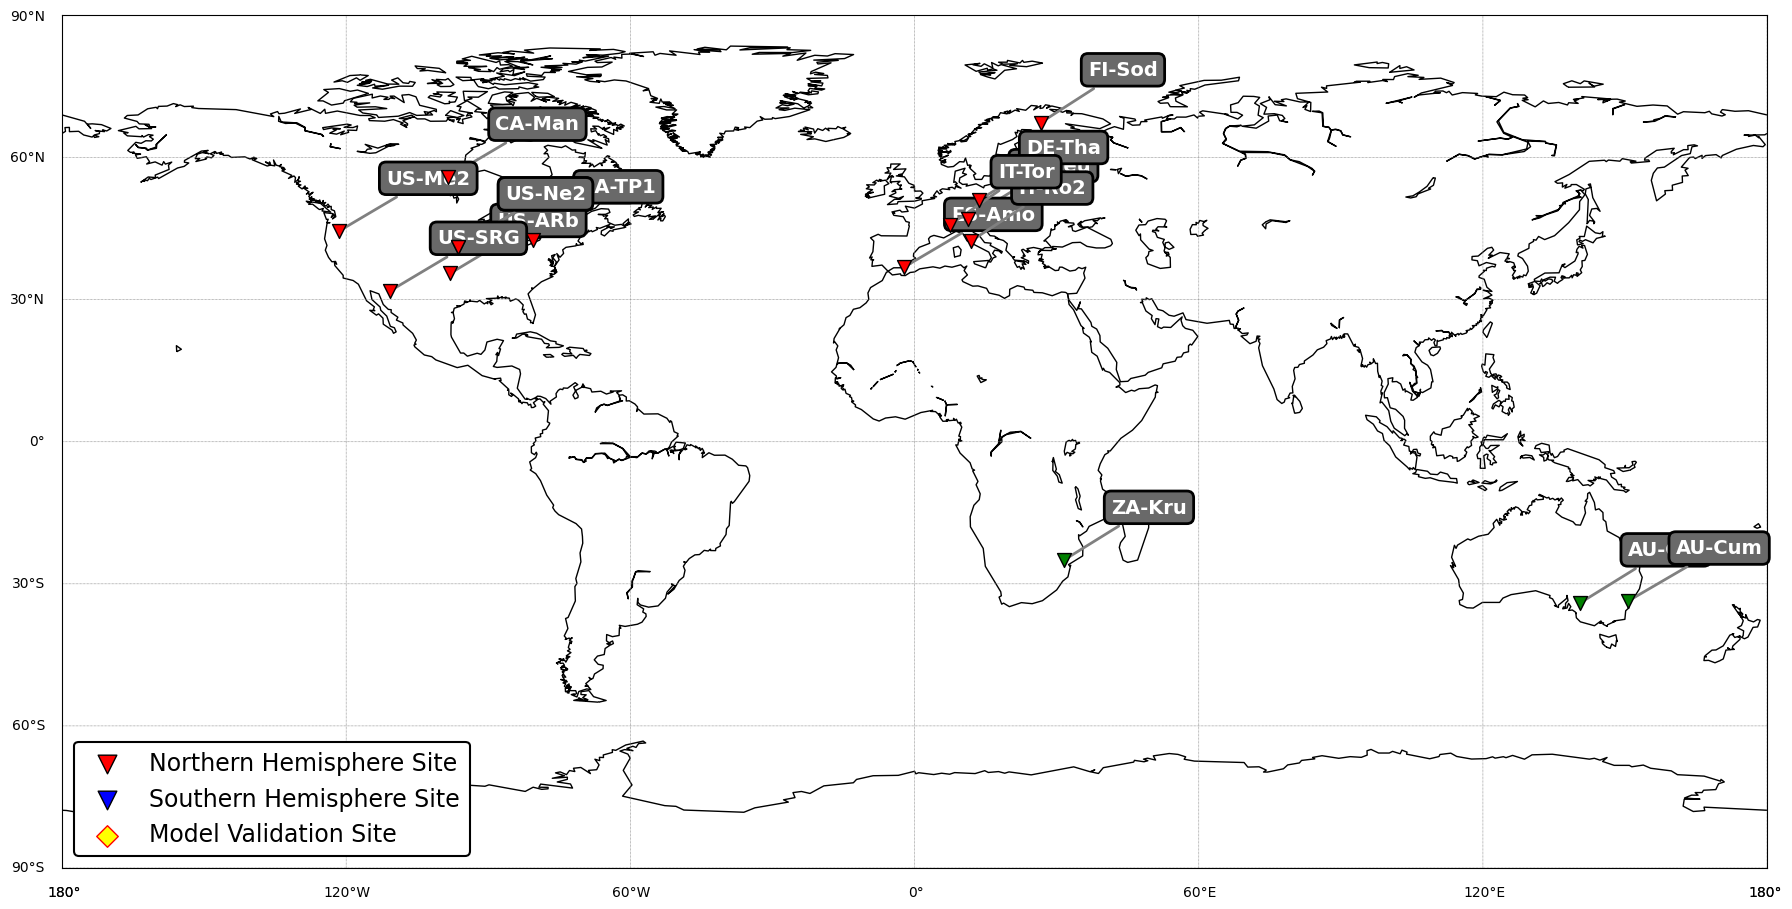

In [102]:
# map of final sites

fig, ax = plt.subplots(figsize=(22, 14))

final_map = Basemap(projection='cyl', llcrnrlat=-90, urcrnrlat=90,
                    llcrnrlon=-180, urcrnrlon=180, resolution='c', ax=ax)

final_map.drawcoastlines()

# add the sites
final_map.scatter(nh_sites_plot['LONG'], nh_sites_plot['LAT'], marker='v', color='red', edgecolor='black', s=100,alpha=1,zorder=5)
final_map.scatter(sh_sites_plot['LONG'], sh_sites_plot['LAT'], marker='v', color='green', edgecolor='black', s=100,alpha=1,zorder=5)


# plot  'US-Var'
final_map.scatter(
    nh_sites_plot[nh_sites_plot['SITE_ID'] == 'US-Var']['LONG'], 
    nh_sites_plot[nh_sites_plot['SITE_ID'] == 'US-Var']['LAT'],
    marker='d', color='yellow', edgecolor='red',lw=2, s=120, alpha=1, zorder=6, label='Model Validation Site'
)



# add lines to map 
parallels = np.arange(-90., 91., 30.)
meridians = np.arange(-180., 181., 60.)
final_map.drawparallels(parallels, labels=[1, 0, 0, 0], linewidth=0.5, color='grey')
final_map.drawmeridians(meridians, labels=[0, 0, 0, 1], linewidth=0.5, color='grey')

# points for legend
dummy_scatter_nh = plt.scatter([], [], color='red', marker='v', alpha=1, s=180, edgecolors='black', label='Northern Hemisphere Site')
dummy_scatter_sh = plt.scatter([], [], color='blue', marker='v', s=180, edgecolors='black', label='Southern Hemisphere Site')
dummy_scatter_validation = plt.scatter([], [], color='yellow', marker='D', s=120, edgecolors='red', label='Model Validation Site')


legend = plt.legend(handles=[dummy_scatter_nh, dummy_scatter_sh,dummy_scatter_validation], loc='lower left', fontsize=17)

frame = legend.get_frame()
frame.set_edgecolor('black')      
frame.set_linewidth(1.5)          
frame.set_alpha(1)

# function for adding sites labels with the custom offsets
def add_labels(sites, color):
    for idx, row in sites.iterrows():
        offset = label_offsets.get(row['SITE_ID'], (10, 10))  # Default offset if not in dictionary
        plt.annotate(
            row['SITE_ID'],
            xy=(row['LONG'], row['LAT']),
            xytext=(row['LONG'] + offset[0], row['LAT'] + offset[1]),
            fontsize=14,
            fontweight='bold',
            color='white',
            arrowprops=dict(arrowstyle='-', color='grey', lw=2),
            bbox=dict(boxstyle="round,pad=0.35", edgecolor='black', facecolor='dimgrey',lw=2)
        )

# add labels
add_labels(nh_sites_plot, 'black') # NH
add_labels(sh_sites_plot, 'black') # SH 

plt.show()

In [105]:
# extract coords for downloading additional 


nh_sites_coord=nh_sites_plot[['SITE_ID','LAT','LONG']]
sh_sites_coord=sh_sites_plot[['SITE_ID','LAT','LONG']]

all_sites_coord = pd.concat([nh_sites_coord, sh_sites_coord], ignore_index=True)
all_sites_coord

,SITE_ID,LAT,LONG
0,AT-Neu,47.1167,11.3175
1,CA-Man,55.8796,-98.4808
2,CA-TP1,42.6609,-80.5595
3,DE-Tha,50.9626,13.5651
4,ES-Amo,36.8336,-2.2523
5,FI-Sod,67.3624,26.6386
6,IT-Ro2,42.3903,11.9209
7,IT-Tor,45.8444,7.5781
8,US-ARb,35.5497,-98.0402
9,US-Me2,44.4526,-121.5589


In [106]:
# filter the  ds to the selected sites 

final_nh=post_2000[post_2000['SITE_ID'].isin(selected_nh)]
final_sh=post_2000[post_2000['SITE_ID'].isin(selected_sh)]


In [107]:
## combine NH and SH sites

selected_sites=np.concatenate([selected_nh,selected_sh]) 

In [109]:
combined_df=pd.concat([final_nh,final_sh],ignore_index=True)

In [110]:
### filter the dataset to only be post 2010

combined_df=combined_df[combined_df['YEAR']>=2010]

In [111]:
combined_df.shape #(25930, 19)

(23010, 20)

In [112]:
combined_df['YEAR'].unique() #double check the filtering

array([2010, 2011, 2012, 2013, 2014])

In [113]:
## extract year, month, day

combined_df['date'] = pd.to_datetime(combined_df[['YEAR', 'MONTH', 'DAY']])


In [114]:
#### -9999 is an instrument error so this needs to be replaced with NA ###

total_negative_9999 = (combined_df == -9999).sum().sum()
print(total_negative_9999) #9965 error (-9999) values 

In [116]:
combined_df.replace(-9999,np.nan,inplace=True) # replace with NA

In [119]:
# create a new df of the entire data range to check for missing days


date_range = pd.date_range(start='2010-01-01', end='2014-12-31', freq='D')


In [120]:
dataframes = []

# loop through the selected site_ids and create df with all dates for each site

for site_id in selected_sites:
    df = pd.DataFrame(date_range, columns=['date'])
    df['SITE_ID'] = site_id
    dataframes.append(df)

In [122]:
# concat the dfs together

all_dates_df = pd.concat(dataframes, ignore_index=True)
all_dates_df

,date,SITE_ID
0,2010-01-01,US-Ne1
1,2010-01-02,US-Ne1
2,2010-01-03,US-Ne1
3,2010-01-04,US-Ne1
4,2010-01-05,US-Ne1
...,...,...
29211,2014-12-27,ZA-Kru
29212,2014-12-28,ZA-Kru
29213,2014-12-29,ZA-Kru
29214,2014-12-30,ZA-Kru


In [123]:
# merged df of the 15 sites and the entire date range including NA 
# on missing values that need imputing

merged=pd.merge(combined_df,all_dates_df,on=['SITE_ID','date'],how='right',indicator=True)

In [124]:
# convert date to pd datetime format and set as the index

merged['date'] = pd.to_datetime(merged['date'])
merged.set_index('date', inplace=True)



In [125]:
merged=merged.drop(columns=['_merge']) 

In [126]:
merged.isna().sum()

SITE_ID               0
TA_F              10224
PA_F              10224
VPD_F             10224
P_F               10224
WS_F              10224
PPFD_IN           15788
PPFD_OUT          20493
CO2_F_MDS         11098
TS_F_MDS_1        11098
SWC_F_MDS_1       15026
NEE_VUT_REF       10224
GPP_DT_VUT_REF    10224
YEAR               8398
MONTH              8398
DAY                8398
LAT                8398
LONG               8398
IGBP               8398
hemisphere         8398
dtype: int64

In [128]:
# drop non-predictive variables from the df for heatmap 

missing_df=merged.drop(columns=['SITE_ID','YEAR','MONTH','DAY','LAT','LONG','IGBP',
                        'hemisphere','NEE_VUT_REF'])

In [130]:
missing_df.sort_index(inplace=True)

In [127]:
# custom labels

var_ax_labs = {
    'TA_F': r'Temperature (°C)',
    'PA_F': r'Surface Pressure (kPa)',
    'VPD_F': r'Vapor Pressure Deficit (hPa)',
    'P_F': r'Precipitation (mm)',
    'WS_F': r'Wind Speed (ms$^{-1}$)',
    'PPFD_IN': r'PPFD ($\mu$mol Photon m$^{-2}$ s$^{-1}$)',
    'CO2_F_MDS': r'CO$_2$ Mole Fraction ($\mu$mol CO$_2$ mol$^{-1}$)',
    'TS_F_MDS_1': r'Soil Temperature (°C)',
    'SWC_F_MDS_1': r'Soil Water Content (\%)',
    'GPP_DT_VUT_REF': r'GPP ($\mu$mol CO$_2$ m$^{-2}$ s$^{-1}$)'
}



In [131]:
ordered_var_labs = [var_ax_labs.get(col, col) for col in missing_df.columns]


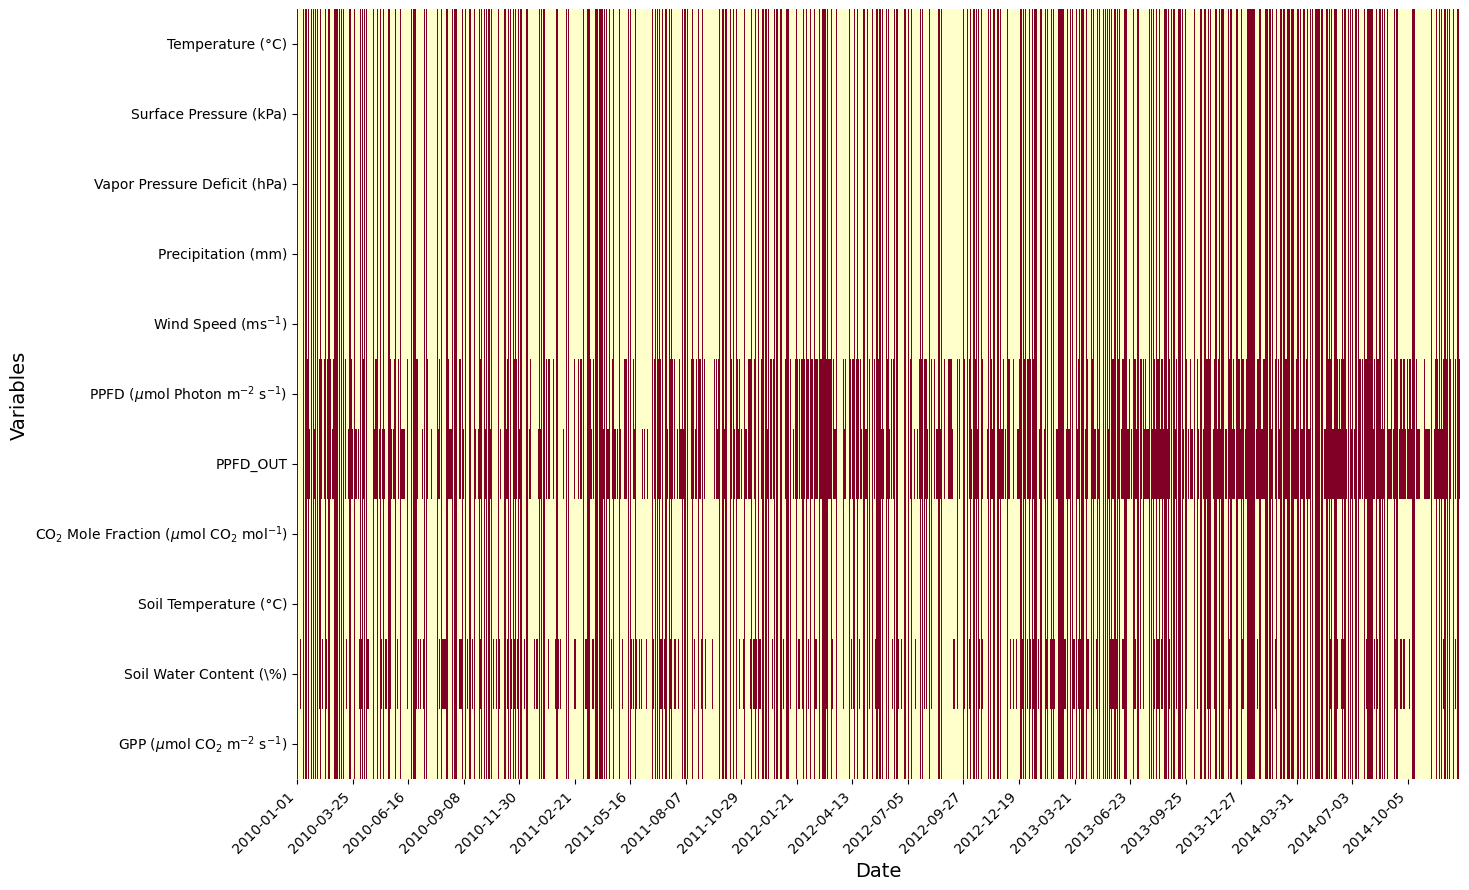

In [132]:
# plot heatmap of the missing data

ax = sns.heatmap(missing_df.isna().transpose(), cbar=False, cmap='YlOrRd',
                 yticklabels=ordered_var_labs)  # Apply labels directly here

# remove time aspect of the date from the x-axis
ax.set_xticks(np.arange(len(missing_df.index))[::1500])  # Show only one tick every 1500 entries
ax.set_xticklabels(missing_df.index.strftime('%Y-%m-%d')[::1500], rotation=45, ha='right')

plt.xlabel('Date', fontsize=14) 
plt.ylabel('Variables', fontsize=14)

plt.show()

In [133]:
print("DataFrame Columns:")
print(missing_df.columns)
print("\nOrdered Labels:")
print(var_ax_labs)

DataFrame Columns:
Index(['TA_F', 'PA_F', 'VPD_F', 'P_F', 'WS_F', 'PPFD_IN', 'PPFD_OUT',
       'CO2_F_MDS', 'TS_F_MDS_1', 'SWC_F_MDS_1', 'GPP_DT_VUT_REF'],
      dtype='object')

Ordered Labels:
{'TA_F': 'Temperature (°C)', 'PA_F': 'Surface Pressure (kPa)', 'VPD_F': 'Vapor Pressure Deficit (hPa)', 'P_F': 'Precipitation (mm)', 'WS_F': 'Wind Speed (ms$^{-1}$)', 'PPFD_IN': 'PPFD ($\\mu$mol Photon m$^{-2}$ s$^{-1}$)', 'CO2_F_MDS': 'CO$_2$ Mole Fraction ($\\mu$mol CO$_2$ mol$^{-1}$)', 'TS_F_MDS_1': 'Soil Temperature (°C)', 'SWC_F_MDS_1': 'Soil Water Content (\\%)', 'GPP_DT_VUT_REF': 'GPP ($\\mu$mol CO$_2$ m$^{-2}$ s$^{-1}$)'}


In [134]:
missing_counts=merged.isna().sum() #No missing values in each column

In [136]:
# work out the counts and percentage of missing values

total_count=len(merged)
total_count #27390

perc_missing=(missing_counts/total_count)*100

missing_percs=pd.DataFrame({'count':missing_counts,'percentage':perc_missing})

missing_percs


,count,percentage
SITE_ID,0,0.000000
TA_F,10224,32.552216
PA_F,10224,32.552216
VPD_F,10224,32.552216
P_F,10224,32.552216
WS_F,10224,32.552216
PPFD_IN,15788,50.267448
PPFD_OUT,20493,65.247708
CO2_F_MDS,11098,35.334947
TS_F_MDS_1,11098,35.334947


In [137]:
#fill in missing years, hemisphere, lat lon and IGBP

merged.reset_index(inplace=True) # reset index to extract date

In [138]:
#redo the date extraction to include the new dates

merged['YEAR']=merged['date'].dt.year
merged['MONTH']=merged['date'].dt.month
merged['DAY']=merged['date'].dt.day

In [139]:
merged.isna().sum() #No missing values for dates anymore

date                  0
SITE_ID               0
TA_F              10224
PA_F              10224
VPD_F             10224
P_F               10224
WS_F              10224
PPFD_IN           15788
PPFD_OUT          20493
CO2_F_MDS         11098
TS_F_MDS_1        11098
SWC_F_MDS_1       15026
NEE_VUT_REF       10224
GPP_DT_VUT_REF    10224
YEAR                  0
MONTH                 0
DAY                   0
LAT                8398
LONG               8398
IGBP               8398
hemisphere         8398
dtype: int64

In [140]:
#now to fill in the missing IGBP and lat lon from site_key then
#can apply the hemisphere function to fill those

def fill_missing(row, key_df):
    
    site_id = row['SITE_ID']
    
    if pd.isna(row['LAT']):
        row['LAT'] = site_key.loc[site_key['SITE_ID'] == row['SITE_ID'], 'LAT'].values[0]
    if pd.isna(row['LONG']):
        row['LONG'] = site_key.loc[site_key['SITE_ID'] == row['SITE_ID'], 'LONG'].values[0]
    if pd.isna(row['IGBP']):
        row['IGBP']=site_key.loc[site_key['SITE_ID']==row['SITE_ID'], 'IGBP'].values[0]
    return row


In [141]:
#apply the function to fill in the missing values from site_key

final_df=merged.apply(fill_missing,axis=1,key_df=site_key)

In [142]:
final_df.isna().sum() #values successfully imputed

date                  0
SITE_ID               0
TA_F              10224
PA_F              10224
VPD_F             10224
P_F               10224
WS_F              10224
PPFD_IN           15788
PPFD_OUT          20493
CO2_F_MDS         11098
TS_F_MDS_1        11098
SWC_F_MDS_1       15026
NEE_VUT_REF       10224
GPP_DT_VUT_REF    10224
YEAR                  0
MONTH                 0
DAY                   0
LAT                   0
LONG                  0
IGBP                  0
hemisphere         8398
dtype: int64

In [143]:
#apply the previous hemisphere function to fillt those missing value

final_df['hemisphere']=final_df['LAT'].apply(lambda x: 'NH' if x>=0 else 'SH')

In [144]:
site_missing=final_df.copy()

In [145]:
site_missing.isna().sum()

date                  0
SITE_ID               0
TA_F              10224
PA_F              10224
VPD_F             10224
P_F               10224
WS_F              10224
PPFD_IN           15788
PPFD_OUT          20493
CO2_F_MDS         11098
TS_F_MDS_1        11098
SWC_F_MDS_1       15026
NEE_VUT_REF       10224
GPP_DT_VUT_REF    10224
YEAR                  0
MONTH                 0
DAY                   0
LAT                   0
LONG                  0
IGBP                  0
hemisphere            0
dtype: int64

In [146]:
# going to create a filled bar chart to show the missing data by site


#group missing data by site_id
sites_missing_counts = site_missing.groupby('SITE_ID').apply(lambda x: x.isnull().sum().sum()).reset_index()

sites_missing_counts.rename(columns={0: 'counts'}, inplace=True)

# add missing gpp values
site_missing['gpp_missing']=site_missing['GPP_DT_VUT_REF'].isna() 

# calculate missing gpp counts
gpp_missing_counts = site_missing.groupby('SITE_ID')['gpp_missing'].sum().reset_index()

gpp_missing_counts.rename(columns={'gpp_missing': 'gpp_counts'}, inplace=True)

#merge missing predictive vars and gpp dfs
sites_missing_counts = pd.merge(sites_missing_counts, gpp_missing_counts, on='SITE_ID', how='left')

total_site_miss=sites_missing_counts['counts'].sum()
total_site_miss #145071

# calculate missing percentages
sites_missing_counts['percentage']=(sites_missing_counts['counts']/total_site_miss)*100

total_gpp_miss=sites_missing_counts['gpp_counts'].sum()

sites_missing_counts['gpp_perc']=(sites_missing_counts['gpp_counts']/total_gpp_miss)*100

pyrealm/3392203001.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.


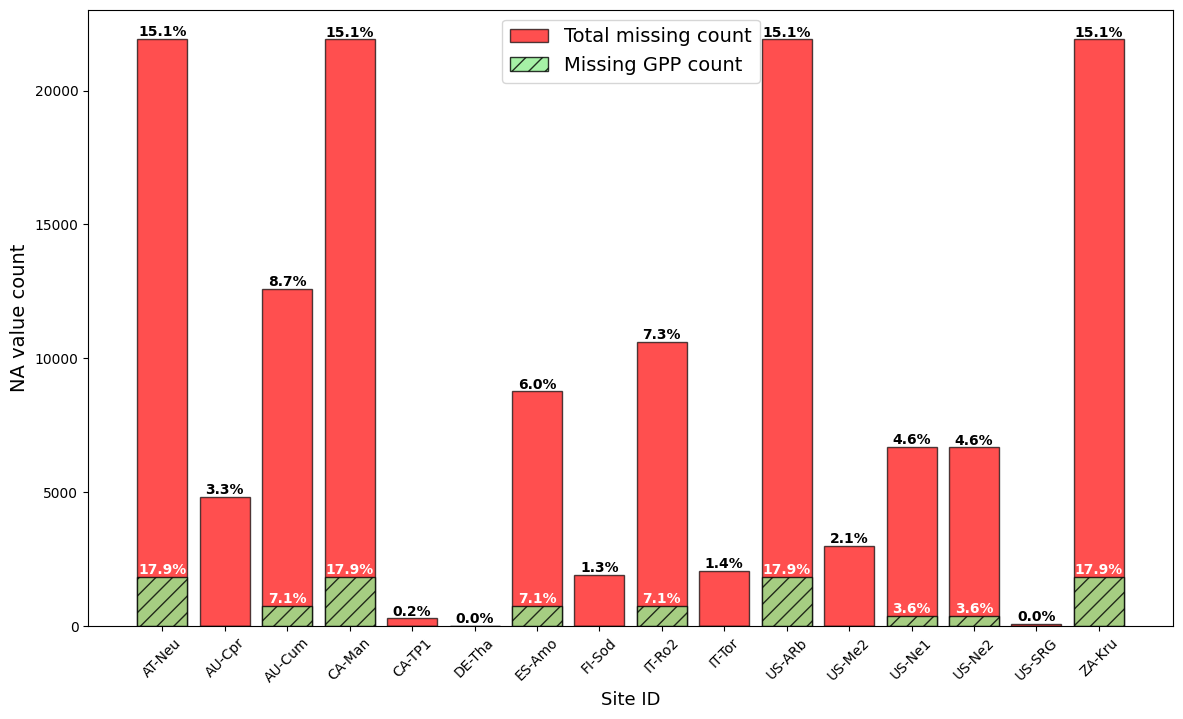

In [164]:
plt.figure(figsize=(14, 8))

bars=plt.bar(sites_missing_counts['SITE_ID'], 
             sites_missing_counts['counts'],
             color='red',edgecolor='black',
             label='Total missing count',
            alpha=0.69)

gpp_bars = plt.bar(sites_missing_counts['SITE_ID'], sites_missing_counts['gpp_counts'], 
                   color='lightgreen', 
                   edgecolor='black', 
                   label='Missing GPP count',
                   hatch='//',alpha=0.8)


# percentage of total missing 

for bar, percentage in zip(bars,sites_missing_counts['percentage']):
    yval=bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.05, f'{percentage:.1f}%',
             ha='center', va='bottom',fontweight='bold')

    
# percentage of gpp missing

for bar, gpp_percentage in zip(gpp_bars, sites_missing_counts['gpp_perc']):
    if gpp_percentage > 0:  # Only show percentage if it's greater than 0
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval + 0.05, f'{gpp_percentage:.1f}%',
                 ha='center', va='bottom', color='white',fontweight='bold')

    
    
    
    
    
plt.xlabel('Site ID',fontsize=13)
plt.ylabel('NA value count',fontsize=14)
plt.xticks(rotation=45)

plt.legend(fontsize=14)


plt.show()

In [168]:
###create a loop to extract all of the NA values per site 

site_na_dict={}

for site_id in final_df['SITE_ID'].unique():
    
    site_df=final_df[final_df['SITE_ID']==site_id].copy()
    
    site_na_df=site_df[site_df.isna().any(axis=1)].copy()
    
    globals()[f"{site_id.replace('-','_')}_NA"]=site_na_df
    

In [169]:
site_na_info = []

# loop through each unique site id and process for rows with NA values
for site_id in final_df['SITE_ID'].unique():
    
    site_df = final_df[final_df['SITE_ID'] == site_id].copy()
    
    # extract rows with NA values
    site_na_df = site_df[site_df.isna().any(axis=1)].copy()
    
    # extract missing value information
    for idx, row in site_na_df.iterrows():
        missing_columns = row[row.isna()].index.tolist()
        for col in missing_columns:
            site_na_info.append({
                'SITE_ID': site_id,
                'year': row['YEAR'],
                'month': row['MONTH'],
                'day': row['DAY'],
                'variable': col
            })

missing_info_df = pd.DataFrame(site_na_info)


In [170]:
### check all of the sites for which missing data needed and the dates (this information is in the report appendix)

site_id_to_check = 'US-PFa'
filtered_df = missing_info_df[missing_info_df['SITE_ID'] == site_id_to_check]
unique_variables = filtered_df['variable'].unique()
unique_variables

array([], dtype=object)

In [171]:
print(f"Unique variables with missing values for SITE_ID '{site_id_to_check}':")
for variable in unique_variables:
    print(f"\nVariable: {variable}")
    variable_dates = filtered_df[filtered_df['variable'] == variable][['year', 'month', 'day']]
    print(variable_dates.to_string(index=False))

Unique variables with missing values for SITE_ID 'US-PFa':


In [ ]:
final_df.to_csv('/Users/abigailbase/PROJECT FILES/Pre imputation data/pre_imp.csv')

In [ ]:
site_key_selected.to_csv('/Users/abigailbase/PROJECT FILES/selected_sites.csv',index=False)